## Wide & Deep Recommender Demo

Wide and Deep Learning Model, proposed by Google in 2016, is a DNN-Linear mixed model. Wide and deep learning has been used for Google App Store for their app recommendation.

In this tutorial, we use Recommender API of Analytics Zoo to build a wide linear model and a deep neural network, which is called Wide&Deep model, and use optimizer of BigDL to train the neural network. Wide&Deep model combines the strength of memorization and generalization. It's useful for generic large-scale regression and classification problems with sparse input features (e.g., categorical features with a large number of possible feature values).

## Intialization

import necessary libraries

In [1]:
from zoo.models.recommendation import *
from zoo.models.recommendation.utils import *
from zoo.common.nncontext import init_nncontext
import os
import sys
import datetime as dt

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Initilaize NN context, it will get a SparkContext with optimized configuration for BigDL performance.

In [2]:
sc = init_nncontext("WideAndDeep Example")

## Data Preparation

Download and read movielens 1M rating data, understand the dimension.

In [3]:
from bigdl.dataset import movielens
movielens_data = movielens.get_id_ratings("/tmp/movielens/")
min_user_id = np.min(movielens_data[:,0])
max_user_id = np.max(movielens_data[:,0])
min_movie_id = np.min(movielens_data[:,1])
max_movie_id = np.max(movielens_data[:,1])
rating_labels= np.unique(movielens_data[:,2])

print(movielens_data.shape)
print(min_user_id, max_user_id, min_movie_id, max_movie_id, rating_labels)


(1000209, 3)
(1, 6040, 1, 3952, array([1, 2, 3, 4, 5]))


Transform ratings into dataframe, read user and item data into dataframes. Transform labels to zero-based since the original labels start from 1.

In [4]:
sqlContext = SQLContext(sc)
from pyspark.sql.types import *
from pyspark.sql import Row

Rating = Row("userId", "itemId", "label")
User = Row("userId", "gender", "age" ,"occupation")
Item = Row("itemId", "title" ,"genres")

ratings = sc.parallelize(movielens_data)\
    .map(lambda l: (int(l[0]), int(l[1]), int(l[2])-1))\
    .map(lambda r: Rating(*r))
ratingDF = sqlContext.createDataFrame(ratings)

users= sc.textFile("/tmp/movielens/ml-1m/users.dat")\
    .map(lambda l: l.split("::")[0:4])\
    .map(lambda l: (int(l[0]), l[1], int(l[2]), int(l[3])))\
    .map(lambda r: User(*r))
userDF = sqlContext.createDataFrame(users)

items = sc.textFile("/tmp/movielens/ml-1m/movies.dat")\
    .map(lambda l: l.split("::")[0:3])\
    .map(lambda l: (int(l[0]), l[1], l[2].split('|')[0]))\
    .map(lambda r: Item(*r))
itemDF = sqlContext.createDataFrame(items)


Join data together, and transform data. For example, gender is going be used as categorical feature, occupation and gender will be used as crossed features.

In [5]:
from pyspark.sql.functions import col, udf

gender_udf = udf(lambda gender: categorical_from_vocab_list(gender, ["F", "M"], start=1))
bucket_cross_udf = udf(lambda feature1, feature2: hash_bucket(str(feature1) + "_" + str(feature2), bucket_size=100))
genres_list = ["Crime", "Romance", "Thriller", "Adventure", "Drama", "Children's",
      "War", "Documentary", "Fantasy", "Mystery", "Musical", "Animation", "Film-Noir", "Horror",
      "Western", "Comedy", "Action", "Sci-Fi"]
genres_udf = udf(lambda genres: categorical_from_vocab_list(genres, genres_list, start=1))
     
allDF = ratingDF.join(userDF, ["userId"]).join(itemDF, ["itemId"]) \
        .withColumn("gender", gender_udf(col("gender")).cast("int")) \
        .withColumn("age-gender", bucket_cross_udf(col("age"), col("gender")).cast("int")) \
        .withColumn("genres", genres_udf(col("genres")).cast("int"))
allDF.show(5)


+------+------+-----+------+---+----------+--------------+------+----------+
|itemId|userId|label|gender|age|occupation|         title|genres|age-gender|
+------+------+-----+------+---+----------+--------------+------+----------+
|    26|  3391|    3|     2| 18|         4|Othello (1995)|     5|        24|
|    26|  1447|    4|     2| 18|         4|Othello (1995)|     5|        24|
|    26|  5107|    3|     1| 45|         0|Othello (1995)|     5|         5|
|    26|  2878|    3|     1| 50|        20|Othello (1995)|     5|        47|
|    26|  1527|    1|     2| 18|        10|Othello (1995)|     5|        24|
+------+------+-----+------+---+----------+--------------+------+----------+
only showing top 5 rows



Speficy data feature information shared by the WideAndDeep model and its feature generation. Here, we use occupation gender for wide base part, age and gender crossed as wide cross part, genres and gender as indicators, userid and itemid for embedding.  

In [6]:
bucket_size = 100
column_info = ColumnFeatureInfo(
            wide_base_cols=["occupation", "gender"],
            wide_base_dims=[21, 3],
            wide_cross_cols=["age-gender"],
            wide_cross_dims=[bucket_size],
            indicator_cols=["genres", "gender"],
            indicator_dims=[19, 3],
            embed_cols=["userId", "itemId"],
            embed_in_dims=[max_user_id, max_movie_id],
            embed_out_dims=[64, 64],
            continuous_cols=["age"])


Transform data to  RDD of Sample. We use optimizer of BigDL directly to train the model, it requires data to be provided in format of RDD(Sample). A Sample is a BigDL data structure which can be constructed using 2 numpy arrays, feature and label respectively. The API interface is Sample.from_ndarray(feature, label).  Wide&Deep model need two input tensors, one is SparseTensor for the Wide model, another is a DenseTensor for the Deep model.

In [7]:
rdds = allDF.rdd.map(lambda row: to_user_item_feature(row, column_info))
trainPairFeatureRdds, valPairFeatureRdds = rdds.randomSplit([0.8, 0.2], seed= 1)
valPairFeatureRdds.persist()
train_data= trainPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)
test_data= valPairFeatureRdds.map(lambda pair_feature: pair_feature.sample)

##  Create the Wide&Deep model.

In Analytics Zoo, it is simple to build Wide&Deep model by calling WideAndDeep API. You need specify model type, and class number, as well as column information of features according to your data. You can also change other default parameters in the network, like hidden layers. The model could be fed into an Optimizer of BigDL or NNClassifier of analytics-zoo. Please refer to the document for more details. In this example, we demostrate how to use optimizer of BigDL.

In [8]:
wide_n_deep = WideAndDeep(5, column_info, "wide_n_deep")

creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasSparseDense
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasEmbedding
creating: createZooKerasFlatten
creating: createZooKerasFlatten
creating: createZooKerasSelect
creating: createZooKerasEmbedding
creating: createZooKerasFlatten
creating: createZooKerasMerge
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasMerge
creating: createZooKerasActivation
creating: createZooKerasModel
creating: createZooWideAndDeep


## Create optimizer and train the model

In [9]:
wide_n_deep.compile(optimizer = "adam",
                    loss= "sparse_categorical_crossentropy",
                    metrics=['accuracy'])


creating: createAdam
creating: createZooKerasSparseCategoricalCrossEntropy
creating: createZooKerasSparseCategoricalAccuracy


In [10]:
tmp_log_dir = create_tmp_path()
wide_n_deep.set_tensorboard(tmp_log_dir, "training_wideanddeep")

Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [11]:
%%time
# Boot training process
wide_n_deep.fit(train_data,
                batch_size = 8000,
                nb_epoch = 10,
                validation_data = test_data)
print("Optimization Done.")

Optimization Done.
CPU times: user 54.3 ms, sys: 19.7 ms, total: 74 ms
Wall time: 2min 30s


## Prediction and recommendation

Zoo models make inferences based on the given data using model.predict(val_rdd) API. A result of RDD is returned. predict_class returns the predicted label.

In [12]:
results = wide_n_deep.predict(test_data)
results.take(5)

results_class = wide_n_deep.predict_class(test_data)
results_class.take(5)

[4, 2, 4, 5, 2]

In the Analytics Zoo, Recommender has provied 3 unique APIs to predict user-item pairs and make recommendations for users or items given candidates.
Predict for user item pairs

In [13]:
userItemPairPrediction = wide_n_deep.predict_user_item_pair(valPairFeatureRdds)
for result in userItemPairPrediction.take(5): print(result)

UserItemPrediction [user_id: 5305, item_id: 26, prediction: 4, probability: 0.447520256042]
UserItemPrediction [user_id: 1150, item_id: 26, prediction: 2, probability: 0.42147180438]
UserItemPrediction [user_id: 4294, item_id: 26, prediction: 4, probability: 0.338612318039]
UserItemPrediction [user_id: 5948, item_id: 26, prediction: 5, probability: 0.385789096355]
UserItemPrediction [user_id: 3825, item_id: 26, prediction: 2, probability: 0.292931675911]


Recommend 3 items for each user given candidates in the feature RDDs

In [14]:
userRecs = wide_n_deep.recommend_for_user(valPairFeatureRdds, 3)
for result in userRecs.take(5): print(result)

UserItemPrediction [user_id: 4904, item_id: 1221, prediction: 5, probability: 0.901316523552]
UserItemPrediction [user_id: 4904, item_id: 593, prediction: 5, probability: 0.890776693821]
UserItemPrediction [user_id: 4904, item_id: 913, prediction: 5, probability: 0.888917982578]
UserItemPrediction [user_id: 1084, item_id: 50, prediction: 5, probability: 0.632001161575]
UserItemPrediction [user_id: 1084, item_id: 912, prediction: 5, probability: 0.584099054337]


Recommend 3 users for each item given candidates in the feature RDDs

In [15]:
itemRecs = wide_n_deep.recommend_for_item(valPairFeatureRdds, 3)
for result in itemRecs.take(5): print(result)

UserItemPrediction [user_id: 1835, item_id: 1084, prediction: 5, probability: 0.745298802853]
UserItemPrediction [user_id: 3864, item_id: 1084, prediction: 5, probability: 0.744241654873]
UserItemPrediction [user_id: 5582, item_id: 1084, prediction: 5, probability: 0.739497065544]
UserItemPrediction [user_id: 4511, item_id: 3764, prediction: 4, probability: 0.44239372015]
UserItemPrediction [user_id: 116, item_id: 3764, prediction: 4, probability: 0.365347951651]


##  Draw the convergence curve

Text(0.5,1,'loss')

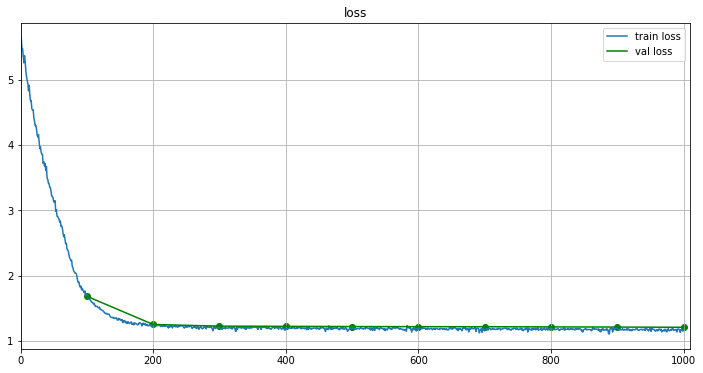

In [16]:
#retrieve train and validation summary object and read the loss data into ndarray's. 
train_loss = np.array(wide_n_deep.get_train_summary("Loss"))
val_loss = np.array(wide_n_deep.get_validation_summary("Loss"))
#plot the train and validation curves
# each event data is a tuple in form of (iteration_count, value, timestamp)
plt.figure(figsize = (12,6))
plt.plot(train_loss[:,0],train_loss[:,1],label='train loss')
plt.plot(val_loss[:,0],val_loss[:,1],label='val loss',color='green')
plt.scatter(val_loss[:,0],val_loss[:,1],color='green')
plt.legend();
plt.xlim(0,train_loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

plot accuracy

(0, 1010)

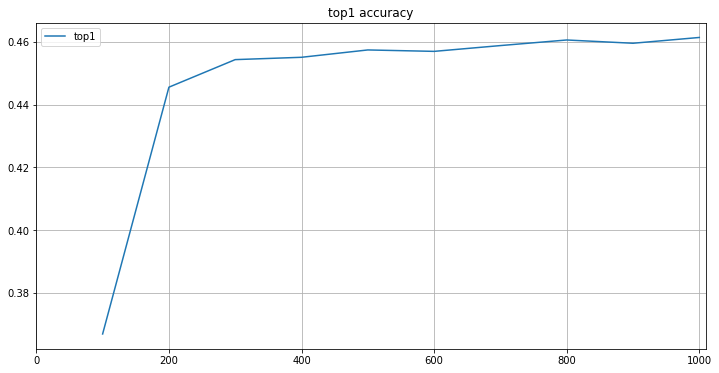

In [17]:
plt.figure(figsize = (12,6))
top1 = np.array(wide_n_deep.get_validation_summary("Top1Accuracy"))
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.title("top1 accuracy")
plt.grid(True)
plt.legend();
plt.xlim(0,train_loss.shape[0]+10)

In [18]:
valPairFeatureRdds.unpersist()

PythonRDD[82] at RDD at PythonRDD.scala:48

In [19]:
sc.stop()